<a href="https://colab.research.google.com/github/mathu3004/Pearl_Path/blob/E_Personalized_Itinerary_Generator/ml_algorithms_manual_filtering_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd  # Data handling and reading CSV/Excel files
import numpy as np  # Numerical operations and matrix manipulations
import re  # Regular expressions for text processing

from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler  # Normalization of numerical features
from sklearn.metrics.pairwise import cosine_similarity  # Similarity calculations for recommendations

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ---------------------------- #
# Step 1: Load Datasets
# ---------------------------- #

user_inputs = pd.read_excel('/content/drive/MyDrive/DSGP_ME/MergedDatasets/user_inputs_preprocessed.xlsx')
Hotels = pd.read_csv('/content/drive/MyDrive/DSGP_ME/MergedDatasets/ProcessedHotels.csv')
Restaurants = pd.read_csv('/content/drive/MyDrive/DSGP_ME/MergedDatasets/PreprocessedRestaurants.csv')
Attractions = pd.read_excel('/content/drive/MyDrive/DSGP_ME/MergedDatasets/attractions_preprocessed.xlsx')

# ---------------------------- #
# Step 2: Clean Column Names (Remove Spaces)
# ---------------------------- #
def clean_column_names(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

user_inputs = clean_column_names(user_inputs)
Hotels = clean_column_names(Hotels)
Restaurants = clean_column_names(Restaurants)
Attractions = clean_column_names(Attractions)

# ---------------------------- #
# Step 3: Encoding Destinations, Cuisines, Amenities, and Dietary Preferences
# ---------------------------- #

# Allowed destinations
allowed_destinations = {'Kandy', 'Ella', 'Colombo', 'Nuwara Eliya'}

# Encode destinations
all_destinations = set()
for dest in user_inputs['destination'].dropna():
    all_destinations.update(dest.split(', '))
destination_encoder = {dest: idx + 1 for idx, dest in enumerate(sorted(all_destinations)) if dest in allowed_destinations}

def encode_destinations(destination_str):
    return [destination_encoder.get(dest.strip()) for dest in destination_str.split(', ') if dest.strip() in destination_encoder]

user_inputs['encoded_destination'] = user_inputs['destination'].apply(encode_destinations)

# Encode cuisines in restaurants
all_cuisines = set()
for cuisines in Restaurants['cuisines'].dropna():
    all_cuisines.update(cuisines.split(', '))
cuisine_encoder = {cuisine: idx + 1 for idx, cuisine in enumerate(sorted(all_cuisines))}

# Encode amenities in hotels
all_amenities = set()
for amenities in Hotels['all_amenities'].dropna():
    all_amenities.update(amenities.split(', '))
amenity_encoder = {amenity: idx + 1 for idx, amenity in enumerate(sorted(all_amenities))}

# Encode dietary restrictions in restaurants
veg_friendly = {'Vegetarian friendly', 'Vegan options', 'Halal', 'Gluten free options'}
non_veg_friendly = {'No Special Dietary'}

def encode_dietary_restrictions(dietary_str):
    if pd.isna(dietary_str):
        return set()
    restrictions = set(dietary_str.split(', '))
    if restrictions & veg_friendly:
        return {1}  # Veg
    elif restrictions & non_veg_friendly:
        return {3}  # Non-Veg
    return set()

Restaurants['encoded_dietaryrestrictions'] = Restaurants['dietaryrestrictions'].apply(encode_dietary_restrictions)

# Apply encoding
Restaurants['encoded_cuisines'] = Restaurants['cuisines'].apply(lambda x: {cuisine_encoder[c] for c in x.split(', ')} if pd.notna(x) else set())
Hotels['encoded_amenities'] = Hotels['all_amenities'].apply(lambda x: {amenity_encoder[a] for a in x.split(', ')} if pd.notna(x) else set())

# Encode user's food preference
food_preference_encoder = {'Veg': 1, 'Non-Veg': 3}
user_inputs['encoded_food_preference'] = user_inputs['food_preference'].map(food_preference_encoder)

# Define the encoding for meal types
meal_type_encoder = {'Breakfast': 3, 'Lunch': 1, 'Dinner': 2, 'General': 1 | 2 | 3}

# Function to encode meal types
def encode_mealtypes(mealtypes_str):
    if pd.isna(mealtypes_str):
        return set()
    return {meal_type_encoder.get(meal.strip(), 0) for meal in mealtypes_str.split(', ')}

# Apply encoding to mealtypes
Restaurants['encoded_mealtypes'] = Restaurants['mealtypes'].apply(encode_mealtypes)

# ---------------------------- #
# Step 4: Extract City Information
# ---------------------------- #
def extract_city(address):
    match = re.search(r'([A-Za-z ]+),? Sri Lanka', str(address))
    return match.group(1).strip() if match else None

Hotels['extracted_city'] = Hotels['address'].apply(extract_city)

# ---------------------------- #
# Step 5: Clean Price Data (Attractions, Restaurants, Hotels, and User Budget)
# ---------------------------- #

# Function to clean the prices
def clean_price(price_str):
    if pd.isna(price_str):
        return None
    if 'No price mentioned' in price_str:
        return None
    price_str = price_str.replace('LKR', '').replace(',', '').strip()
    try:
        return float(price_str)
    except ValueError:
        return None

# Clean 'Lowest_Price' in Attractions
Attractions['Lowest_Price'] = Attractions['Lowest_Price'].apply(clean_price)

# Clean 'priceRange_LKR' in Hotels
Hotels['pricerange'] = Hotels['pricerange'].apply(clean_price)

# Clean 'budget_per_day' in user inputs
def clean_budget(budget_str):
    if pd.isna(budget_str):
        return None
    if 'Rs.' not in budget_str:
        return None
    budget_str = budget_str.replace('Rs.', '').replace(',', '').strip()
    if '-' in budget_str:
        lower, upper = budget_str.split(' - ')
        return (float(lower.strip()), float(upper.strip()))
    elif '+' in budget_str:
        return float(budget_str.replace('+', '').strip())
    return float(budget_str.strip())

user_inputs['cleaned_budget_per_day'] = user_inputs['budget_per_day'].apply(clean_budget)

# ---------------------------- #
# Step 6: Matching Functions (With Budget Constraints)
# ---------------------------- #

def match_best_hotels(user_budget, user_destination, hotels_df):
    hotels_in_city = hotels_df[hotels_df['extracted_city'] == user_destination]
    hotels_in_city = hotels_in_city[hotels_in_city['pricerange'] <= user_budget] if isinstance(user_budget, float) else hotels_in_city
    return hotels_in_city.sort_values(by=['rating', 'rankingposition'], ascending=[False, True])

def match_best_restaurants(user_cuisine_pref, user_food_pref, user_destination, restaurants_df, user_budget):
    if user_destination not in allowed_destinations:
        return pd.DataFrame()

    # Filter restaurants based on meal types
    restaurants_in_city = restaurants_df[restaurants_df['addressobj_city'] == user_destination].copy()

    # Get user's encoded cuisines and food preference
    user_encoded_cuisines = {cuisine_encoder.get(c, 0) for c in user_cuisine_pref.split(', ') if c in cuisine_encoder}
    user_encoded_food_pref = food_preference_encoder.get(user_food_pref, 3)

    # Ensure the meal type is part of the restaurant's offering
    available_mealtypes = {1, 2, 3}  # Include all meals by default (Lunch, Dinner, Breakfast)

    def calculate_match_score(row):
        cuisine_score = len(user_encoded_cuisines.intersection(row['encoded_cuisines']))
        dietary_score = int(user_encoded_food_pref in row['encoded_dietaryrestrictions'])
        meal_type_score = len(available_mealtypes.intersection(row['encoded_mealtypes']))
        return cuisine_score + dietary_score + meal_type_score

    restaurants_in_city['match_score'] = restaurants_in_city.apply(calculate_match_score, axis=1)

    # Filter by budget
    restaurants_in_city = restaurants_in_city[restaurants_in_city['pricelevel_lkr'] <= user_budget] if isinstance(user_budget, float) else restaurants_in_city

    # Sort by match score, highest to lowest
    return restaurants_in_city.sort_values(by='match_score', ascending=False)


def match_best_attractions(user_budget, user_destination, attractions_df):
    if user_destination not in allowed_destinations:
        return pd.DataFrame()

    # Handle the case where the budget is a range (tuple)
    if isinstance(user_budget, tuple):
        min_budget, max_budget = user_budget
        attractions_in_city = attractions_df[(attractions_df['City'] == user_destination) &
                                             (attractions_df['Lowest_Price'] >= min_budget) &
                                             (attractions_df['Lowest_Price'] <= max_budget)]
    else:
        attractions_in_city = attractions_df[(attractions_df['City'] == user_destination) &
                                             (attractions_df['Lowest_Price'] <= user_budget)]

    return attractions_in_city.sort_values(by=['Rating', 'Ranking_Position'], ascending=[False, True])

# ---------------------------- #
# Step 8: Feature Engineering for Content-Based Filtering
# ---------------------------- #

def replace_not_rated(value, median_value):
    return median_value if value == 'not rated' else value

def replace_no_ranking(value, median_value):
    return median_value if value == 'no ranking' else value

# Convert 'not rated' and 'no ranking' values to NaN, compute median, and replace
Attractions['Rating'] = pd.to_numeric(Attractions['Rating'], errors='coerce')
median_attraction_rating = Attractions['Rating'].median()
Attractions['Rating'].fillna(median_attraction_rating, inplace=True)

Hotels['rating'] = pd.to_numeric(Hotels['rating'], errors='coerce')
median_hotel_rating = Hotels['rating'].median()
Hotels['rating'].fillna(median_hotel_rating, inplace=True)

Attractions['Ranking_Position'] = pd.to_numeric(Attractions['Ranking_Position'], errors='coerce')
median_attraction_ranking = Attractions['Ranking_Position'].median()
Attractions['Ranking_Position'].fillna(median_attraction_ranking, inplace=True)

Hotels['rankingposition'] = pd.to_numeric(Hotels['rankingposition'], errors='coerce')
median_hotel_ranking = Hotels['rankingposition'].median()
Hotels['rankingposition'].fillna(median_hotel_ranking, inplace=True)

# Normalize and transform data for similarity calculations
def create_feature_matrix(df, feature_columns):
    scaler = StandardScaler()
    feature_matrix = scaler.fit_transform(df[feature_columns].fillna(0))
    return feature_matrix

# Feature columns for hotels and attractions
hotel_features = ['rating', 'rankingposition', 'pricerange']
attraction_features = ['Rating', 'Ranking_Position', 'Lowest_Price']

Hotels['feature_matrix'] = list(create_feature_matrix(Hotels, hotel_features))
Attractions['feature_matrix'] = list(create_feature_matrix(Attractions, attraction_features))

# ---------------------------- #
# Step 9: Content-Based Filtering for Hotels
# ---------------------------- #

def recommend_similar_hotels(hotel_df, user_budget, user_destination, top_n=5):
    hotels_in_city = hotel_df[hotel_df['extracted_city'] == user_destination].copy()
    if isinstance(user_budget, float):
        hotels_in_city = hotels_in_city[hotels_in_city['pricerange'] <= user_budget]

    if hotels_in_city.empty:
        return pd.DataFrame()

    feature_matrix = np.stack(hotels_in_city['feature_matrix'].values)
    similarity_matrix = cosine_similarity(feature_matrix)

    # Rank hotels based on similarity to all other hotels
    avg_similarity = similarity_matrix.mean(axis=1)
    hotels_in_city.loc[:, 'similarity_score'] = avg_similarity
    return hotels_in_city.sort_values(by=['similarity_score', 'rating', 'rankingposition'], ascending=[False, False, True]).head(top_n)

# ---------------------------- #
# Step 10: Collaborative Filtering for Hotels
# ---------------------------- #

# Create a pseudo user-item matrix where hotels are treated as "users" and ratings as interactions
hotel_ratings_matrix = Hotels[['name', 'rating', 'rankingposition']].copy()

# Normalize data
scaler = StandardScaler()
hotel_ratings_matrix[['rating', 'rankingposition']] = scaler.fit_transform(
    hotel_ratings_matrix[['rating', 'rankingposition']]
)

# Pivot table to create an implicit user-item matrix
hotel_ratings_pivot = hotel_ratings_matrix.pivot_table(index='name', values='rating', fill_value=0)

# Convert DataFrame to NumPy array
hotel_ratings_pivot_np = hotel_ratings_pivot.to_numpy()

# Get matrix dimensions
num_hotels, num_features = hotel_ratings_pivot_np.shape

# Ensure k is within valid range
valid_k = max(1, min(50, min(num_hotels, num_features) - 1))

# Print debug info
print(f"Matrix shape: {hotel_ratings_pivot_np.shape}")
print(f"Valid k: {valid_k}")
print(f"Contains NaN: {np.isnan(hotel_ratings_pivot_np).any()}")
print(f"Contains Inf: {np.isinf(hotel_ratings_pivot_np).any()}")
print(f"All Zeros: {np.all(hotel_ratings_pivot_np == 0)}")

# Handle potential issues before SVD
if np.isnan(hotel_ratings_pivot_np).any():
    print("Replacing NaN values with 0.")
    hotel_ratings_pivot_np = np.nan_to_num(hotel_ratings_pivot_np)

if np.all(hotel_ratings_pivot_np == 0):
    print("All-zero matrix detected. Skipping SVD.")
else:
    try:
        # Perform Singular Value Decomposition (SVD)
        U, sigma, Vt = svds(hotel_ratings_pivot_np, k=valid_k)
        sigma = np.diag(sigma)  # Convert sigma into a diagonal matrix
        print("SVD completed successfully!")
    except Exception as e:
        print(f"Error in SVD: {e}")
        U = sigma = Vt = None  # Ensure these variables are set to None if SVD fails

# Proceed only if SVD was successful
if U is not None and sigma is not None and Vt is not None:
    # Compute predicted ratings
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    hotel_pred_df = pd.DataFrame(predicted_ratings, index=hotel_ratings_pivot.index, columns=hotel_ratings_pivot.columns)

    # Function to recommend hotels based on predicted ratings
    def recommend_collaborative_hotels(hotels_df, top_n=5):
        avg_ratings = hotel_pred_df.mean(axis=1)  # Average predicted rating per hotel
        recommended_hotels = hotels_df[hotels_df['name'].isin(avg_ratings.index)].copy()
        recommended_hotels['predicted_rating'] = recommended_hotels['name'].map(avg_ratings)

        return recommended_hotels.sort_values(by=['predicted_rating', 'rating', 'rankingposition'],
                                              ascending=[False, False, True]).head(top_n)
else:
    print("SVD failed, skipping hotel recommendation.")

# ---------------------------- #
# Step 11: Collaborative Filtering for Attractions
# ---------------------------- #

# Create a pseudo user-item matrix where attractions are treated as "users" and ratings as interactions
attraction_ratings_matrix = Attractions[['Name', 'Rating', 'Ranking_Position']].copy()

# Normalize data
scaler = StandardScaler()
attraction_ratings_matrix[['Rating', 'Ranking_Position']] = scaler.fit_transform(
    attraction_ratings_matrix[['Rating', 'Ranking_Position']]
)

# Pivot table to create an implicit user-item matrix
attraction_ratings_pivot = attraction_ratings_matrix.pivot_table(index='Name', values='Rating', fill_value=0)

# Convert DataFrame to NumPy array
attraction_ratings_pivot_np = attraction_ratings_pivot.to_numpy()

# Get matrix dimensions
num_attractions, num_features = attraction_ratings_pivot_np.shape

# Ensure k is within valid range
valid_k = max(1, min(50, min(num_attractions, num_features) - 1))

# Print debug info
print(f"Matrix shape: {attraction_ratings_pivot_np.shape}")
print(f"Valid k: {valid_k}")
print(f"Contains NaN: {np.isnan(attraction_ratings_pivot_np).any()}")
print(f"Contains Inf: {np.isinf(attraction_ratings_pivot_np).any()}")
print(f"All Zeros: {np.all(attraction_ratings_pivot_np == 0)}")

# Handle potential issues before SVD
if np.isnan(attraction_ratings_pivot_np).any():
    print("Replacing NaN values with 0.")
    attraction_ratings_pivot_np = np.nan_to_num(attraction_ratings_pivot_np)

if np.all(attraction_ratings_pivot_np == 0):
    print("All-zero matrix detected. Skipping SVD.")
else:
    try:
        # Perform Singular Value Decomposition (SVD)
        U, sigma, Vt = svds(attraction_ratings_pivot_np, k=valid_k)
        sigma = np.diag(sigma)  # Convert sigma into a diagonal matrix
        print("SVD completed successfully!")
    except Exception as e:
        print(f"Error in SVD: {e}")
        U = sigma = Vt = None  # Ensure these variables are set to None if SVD fails

# Proceed only if SVD was successful
if U is not None and sigma is not None and Vt is not None:
    # Compute predicted ratings
    predicted_ratings_attractions = np.dot(np.dot(U, sigma), Vt)
    attraction_pred_df = pd.DataFrame(predicted_ratings_attractions, index=attraction_ratings_pivot.index, columns=attraction_ratings_pivot.columns)

    # Function to recommend attractions based on predicted ratings
    def recommend_collaborative_attractions(attractions_df, top_n=5):
        avg_ratings = attraction_pred_df.mean(axis=1)  # Average predicted rating per attraction
        recommended_attractions = attractions_df[attractions_df['Name'].isin(avg_ratings.index)].copy()
        recommended_attractions['predicted_rating'] = recommended_attractions['Name'].map(avg_ratings)

        return recommended_attractions.sort_values(by=['predicted_rating', 'Rating', 'Ranking_Position'],
                                                   ascending=[False, False, True]).head(top_n)
else:
    print("SVD failed, skipping attraction recommendation.")

# ---------------------------- #
# Step 12: Integrating Enhanced Recommendations into Itinerary
# ---------------------------- #

for index, user in user_inputs.iterrows():
    destinations = user['destination'].split(', ')
    num_days = user['number_of_days']
    selected_destinations = destinations[:2] if num_days >= 4 else [destinations[0]]

    print(f"\n===== User {index + 1}: {user['name']} =====")
    print(f"Destination: {', '.join(selected_destinations)}")
    print(f"Cuisine Preference: {user['cuisine_preference']}")
    print(f"Food Preference: {user['food_preference']}")
    print(f"Budget Per Day: {user['budget_per_day']}")

    hotel_stay_counter = 0  # Track how long user stays in a hotel
    current_hotel = None  # Store the current hotel

    for day in range(num_days):
        current_destination = selected_destinations[min(day // 2, len(selected_destinations) - 1)]

        # Change hotel if the user is on the first day or if they've been in the same hotel for 3 days
        if hotel_stay_counter == 0 or hotel_stay_counter >= 3:
            recommended_hotels = recommend_similar_hotels(Hotels, user['cleaned_budget_per_day'], current_destination)
            if not recommended_hotels.empty:
                current_hotel = recommended_hotels.iloc[0]
                hotel_stay_counter = 1  # Reset the counter after changing hotel
            else:
                print("No hotels found for the selected destination and budget.")
                continue
        else:
            hotel_stay_counter += 1  # Increment stay counter if continuing in the same hotel

        # Recommend attractions and restaurants
        recommended_attractions = match_best_attractions(user['cleaned_budget_per_day'], current_destination, Attractions)
        recommended_restaurants = match_best_restaurants(user['cuisine_preference'], user['food_preference'], current_destination, Restaurants, user['cleaned_budget_per_day'])

        if recommended_restaurants.empty:
            print(f"No restaurants found for {current_destination} on Day {day + 1}.")
            continue

        if recommended_attractions.empty:
            print(f"No attractions found for {current_destination} on Day {day + 1}.")
            continue

        # Assign meals and attractions to the day
        breakfast_restaurant = recommended_restaurants.iloc[day % len(recommended_restaurants)]
        attraction_1 = recommended_attractions.iloc[day % len(recommended_attractions)]
        lunch_restaurant = recommended_restaurants.iloc[(day + 1) % len(recommended_restaurants)]
        attraction_2 = recommended_attractions.iloc[(day + 1) % len(recommended_attractions)]
        dinner_restaurant = recommended_restaurants.iloc[(day + 2) % len(recommended_restaurants)]

        # Print the itinerary for the day with dietary restrictions
        print(f"\nDay {day + 1} - {current_destination}")
        print(f"Hotel: {current_hotel['name']} (Rating: {current_hotel['rating']})")
        print(f"Breakfast: {breakfast_restaurant['name']} (Cuisines: {breakfast_restaurant['cuisines']}, Meal Types: {breakfast_restaurant['mealtypes']}, Dietary Restrictions: {breakfast_restaurant['dietaryrestrictions']})")
        print(f"Attraction 1: {attraction_1['Name']} (Lowest Price: {attraction_1['Lowest_Price']})")
        print(f"Lunch: {lunch_restaurant['name']} (Cuisines: {lunch_restaurant['cuisines']}, Meal Types: {lunch_restaurant['mealtypes']}, Dietary Restrictions: {lunch_restaurant['dietaryrestrictions']})")
        print(f"Attraction 2: {attraction_2['Name']} (Lowest Price: {attraction_2['Lowest_Price']})")
        print(f"Dinner: {dinner_restaurant['name']} (Cuisines: {dinner_restaurant['cuisines']}, Meal Types: {dinner_restaurant['mealtypes']}, Dietary Restrictions: {dinner_restaurant['dietaryrestrictions']})")
        print("Returning to Hotel\n")
        print("-" * 40)


<ipython-input-4-64e8215bd12a>:202: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Attractions['Rating'].fillna(median_attraction_rating, inplace=True)
<ipython-input-4-64e8215bd12a>:206: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Streaming output truncated to the last 5000 lines.
Attraction 1: Lover's Leap Falls (Lowest Price: 7611.24)
Lunch: Spice & Rice Hut By Fair View (Cuisines: Asian, Sri Lankan, Meal Types: Breakfast, Lunch, Dinner, Dietary Restrictions: No Special Dietary)
Attraction 2: Pedro Tea Factory (Lowest Price: 7611.24)
Dinner: Genuine Humbugs Restaurant & Inn (Cuisines: Asian, Sri Lankan, Meal Types: Breakfast, Lunch, Dinner, Brunch, Dietary Restrictions: No Special Dietary)
Returning to Hotel

----------------------------------------

===== User 150: Daham  =====
Destination: Nuwara Eliya
Cuisine Preference: Sri Lankan, Indian, Italian, Western
Food Preference: Non-Veg
Budget Per Day: Rs. 5100 - Rs. 10000

Day 1 - Nuwara Eliya
Hotel: Serenus Boutique Villa (Rating: 4.5)
Breakfast: Midky Restaurant (Cuisines: Italian, Chinese, Indian, Asian, Sri Lankan, Arabic, Meal Types: Breakfast, Lunch, Dinner, Dietary Restrictions: No Special Dietary)
Attraction 1: Lover's Leap Falls (Lowest Price: 7611.24)

Testing SVD Reconstruction Error:
SVD Reconstruction Error (MSE): 0.0254

Testing Clustering Evaluation:
Silhouette Score: 0.0847

Testing Classification Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.57      0.50        44
           1       0.57      0.45      0.50        56

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.51      0.50      0.50       100



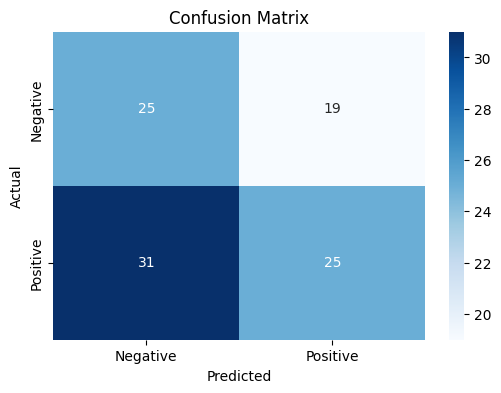

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from scipy.sparse.linalg import svds

# Sample function to evaluate collaborative filtering (SVD reconstruction error)
def evaluate_svd_recommendations(ratings_matrix, k=50):
    """
    Evaluates SVD-based collaborative filtering recommendations
    by computing reconstruction error.
    """
    U, sigma, Vt = svds(ratings_matrix, k=min(k, min(ratings_matrix.shape)-1))
    sigma = np.diag(sigma)
    reconstructed_matrix = np.dot(np.dot(U, sigma), Vt)

    mse = np.mean((ratings_matrix - reconstructed_matrix) ** 2)
    print(f"SVD Reconstruction Error (MSE): {mse:.4f}")
    return mse

# Sample function for silhouette analysis on clustering-based recommendations
def evaluate_clustering(model, X):
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Silhouette Score: {score:.4f}")
    return score

# Sample function for classification-based recommendations (if applicable)
def evaluate_classification(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# ---- TESTING THE FUNCTIONS ----

# 1. Test SVD Reconstruction Error
np.random.seed(42)
ratings_matrix = np.random.rand(100, 50)  # Simulated 100 users × 50 items matrix
print("Testing SVD Reconstruction Error:")
evaluate_svd_recommendations(ratings_matrix, k=20)

# 2. Test Clustering Evaluation
np.random.seed(42)
X_cluster = np.random.rand(100, 10)  # Simulated 100 data points with 10 features
kmeans = KMeans(n_clusters=3, random_state=42)
print("\nTesting Clustering Evaluation:")
evaluate_clustering(kmeans, X_cluster)

# 3. Test Classification Evaluation
np.random.seed(42)
y_true = np.random.randint(0, 2, 100)  # Random 0s and 1s as true labels
y_pred = np.random.randint(0, 2, 100)  # Random 0s and 1s as predicted labels
print("\nTesting Classification Evaluation:")
evaluate_classification(y_true, y_pred)
